In [22]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import random

from matplotlib.ticker import StrMethodFormatter
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from keras.layers import Bidirectional

from tensorflow.random import set_seed
set_seed(42)

%matplotlib inline

In [2]:
plt.style.use('ggplot')

In [3]:
# Check library version 
print('Numpy: ', np.__version__)
print('Pandas: ', pd.__version__)
print('Seaborn: ', sns.__version__)

Numpy:  1.22.4
Pandas:  1.5.3
Seaborn:  0.11.1


In [4]:
loc = "version1_data\dataset.xlsx"
sheet_name = "electdata"
dataset = pd.read_excel(open(loc, 'rb'), sheet_name=sheet_name, engine = 'openpyxl')
dataset.columns = dataset.columns.astype(str)
dataset

,HouseID,cluster,2022-01-01 00:00:00,2022-01-01 01:00:00,2022-01-01 02:00:00,2022-01-01 03:00:00,2022-01-01 04:00:00,2022-01-01 05:00:00,2022-01-01 06:00:00,2022-01-01 07:00:00,...,2022-12-31 14:00:00,2022-12-31 15:00:00,2022-12-31 16:00:00,2022-12-31 17:00:00,2022-12-31 18:00:00,2022-12-31 19:00:00,2022-12-31 20:00:00,2022-12-31 21:00:00,2022-12-31 22:00:00,2022-12-31 23:00:00
0,1,2,717,926,431,558,436,511,1123,530,...,939,1316,1386,1239,3300,1772,3443,1991,2314,1956
1,3,7,772,769,856,741,638,628,612,5331,...,4928,2026,1354,2210,2526,3025,4364,2493,3769,1279
2,4,4,109,88,97,0,169,0,155,258,...,388,1441,1484,312,621,454,685,742,582,519
3,8,5,593,441,353,382,313,368,357,315,...,555,334,423,3492,2944,463,783,1330,2024,688
4,12,4,918,504,473,480,471,415,3564,5523,...,600,683,658,1283,1602,2239,1788,1955,1692,556
5,13,6,193,296,117,129,153,151,1761,11354,...,1862,367,446,550,713,641,1073,889,661,446
6,16,3,856,718,603,548,434,514,531,388,...,1048,815,410,486,787,998,1576,1315,1191,738
7,17,4,275,421,624,738,737,2127,521,4113,...,803,824,397,568,2656,1041,901,1008,3390,405
8,18,4,109,110,110,110,110,110,108,106,...,195,250,148,148,150,534,1661,1939,152,153
9,19,4,107,98,83,78,79,78,76,3022,...,855,483,300,276,2068,1050,857,694,774,1382


In [5]:
data_cluster = dataset.iloc[:,1:].groupby('cluster').mean()
data_cluster = data_cluster.T
data_cluster

cluster,1,2,3,4,5,6,7
2022-01-01 00:00:00,413.692308,716.50,608.333333,311.666667,510.333333,431.750,787.8
2022-01-01 01:00:00,340.923077,925.75,594.444444,627.500000,396.666667,426.625,1355.6
2022-01-01 02:00:00,293.307692,430.75,602.444444,326.555556,257.333333,413.625,1173.2
2022-01-01 03:00:00,305.538462,558.50,529.666667,324.277778,286.000000,432.750,784.8
2022-01-01 04:00:00,466.153846,435.50,474.111111,302.388889,322.333333,373.125,712.0
...,...,...,...,...,...,...,...
2022-12-31 19:00:00,536.153846,1185.25,1311.000000,1450.611111,663.666667,633.750,2868.4
2022-12-31 20:00:00,904.769231,1590.00,1725.444444,1467.388889,721.333333,826.375,4456.8
2022-12-31 21:00:00,620.153846,1332.25,2558.000000,1490.722222,1123.666667,676.000,2550.2
2022-12-31 22:00:00,690.230769,1652.50,1056.444444,1357.333333,1318.000000,543.500,3571.8


In [6]:
data_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       8760 non-null   float64
 1   2       8760 non-null   float64
 2   3       8760 non-null   float64
 3   4       8760 non-null   float64
 4   5       8760 non-null   float64
 5   6       8760 non-null   float64
 6   7       8760 non-null   float64
dtypes: float64(7)
memory usage: 547.5+ KB


In [7]:
data_cluster.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
1,8760.0,814.236310,340.463401,202.230769,554.134615,758.192308,1017.423077,2586.461538
2,8760.0,1020.317951,516.148495,118.250000,697.500000,890.625000,1196.875000,5181.750000
3,8760.0,1107.852156,488.998152,31.666667,751.638889,1009.333333,1359.555556,4694.222222
4,8760.0,1288.556697,568.276951,238.500000,876.166667,1203.722222,1595.402778,4457.222222
5,8760.0,1331.704985,869.762871,123.000000,693.666667,1075.666667,1715.416667,7248.666667
6,8760.0,1085.838499,619.565307,144.625000,634.250000,941.375000,1372.875000,5305.250000
7,8760.0,1988.571393,1151.751135,148.200000,1146.300000,1685.400000,2503.400000,8736.000000


In [8]:
data_cluster.index =pd.to_datetime(data_cluster.index)
data_cluster.index

DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 01:00:00',
               '2022-01-01 02:00:00', '2022-01-01 03:00:00',
               '2022-01-01 04:00:00', '2022-01-01 05:00:00',
               '2022-01-01 06:00:00', '2022-01-01 07:00:00',
               '2022-01-01 08:00:00', '2022-01-01 09:00:00',
               ...
               '2022-12-31 14:00:00', '2022-12-31 15:00:00',
               '2022-12-31 16:00:00', '2022-12-31 17:00:00',
               '2022-12-31 18:00:00', '2022-12-31 19:00:00',
               '2022-12-31 20:00:00', '2022-12-31 21:00:00',
               '2022-12-31 22:00:00', '2022-12-31 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq=None)

In [9]:
# Dataset timeframe
print('Dataset start', data_cluster.index.min())
print('Dataset end', data_cluster.index.max())
print('Dataset spans', data_cluster.index.max() - data_cluster.index.min())

Dataset start 2022-01-01 00:00:00
Dataset end 2022-12-31 23:00:00
Dataset spans 364 days 23:00:00


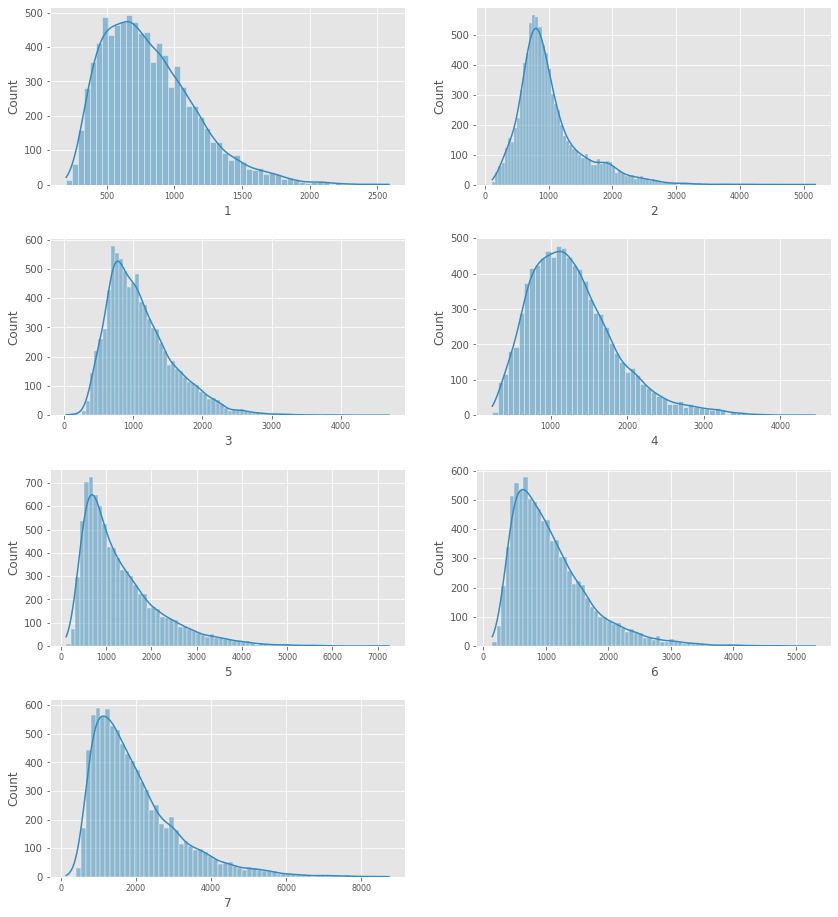

In [10]:
## Histograms: Plotting feature distributions

# Features to plot
columns = data_cluster.columns

# Creating subplot axes
fig, axes = plt.subplots(4, 2, figsize=(14,16), sharey=False)
axes[3,1].set_axis_off()

# Iterating through axes and columns
for col, ax in zip(columns, axes.flatten()):
    sns.histplot(x=col, kde=True, data=data_cluster, ax=ax)
    ax.tick_params(axis='x', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.3);

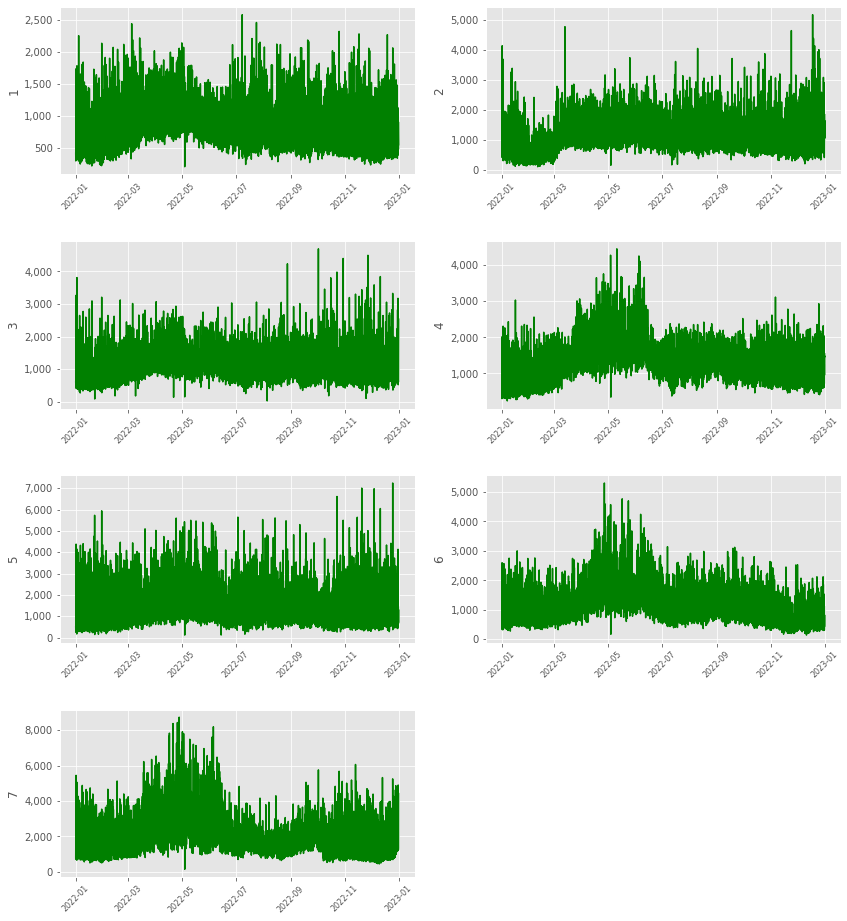

In [11]:
## Plotting features over time

# Features to plot
columns = data_cluster.columns

# Creating subplot axes
fig, axes = plt.subplots(4, 2, figsize=(14,16), sharey=False)
axes[3,1].set_axis_off()

# Iterating through axes and columns
for col, ax in zip(columns, axes.flatten()):
    sns.lineplot(data=data_cluster, x=data_cluster.index, y=col, ax=ax, color='green')
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.4);

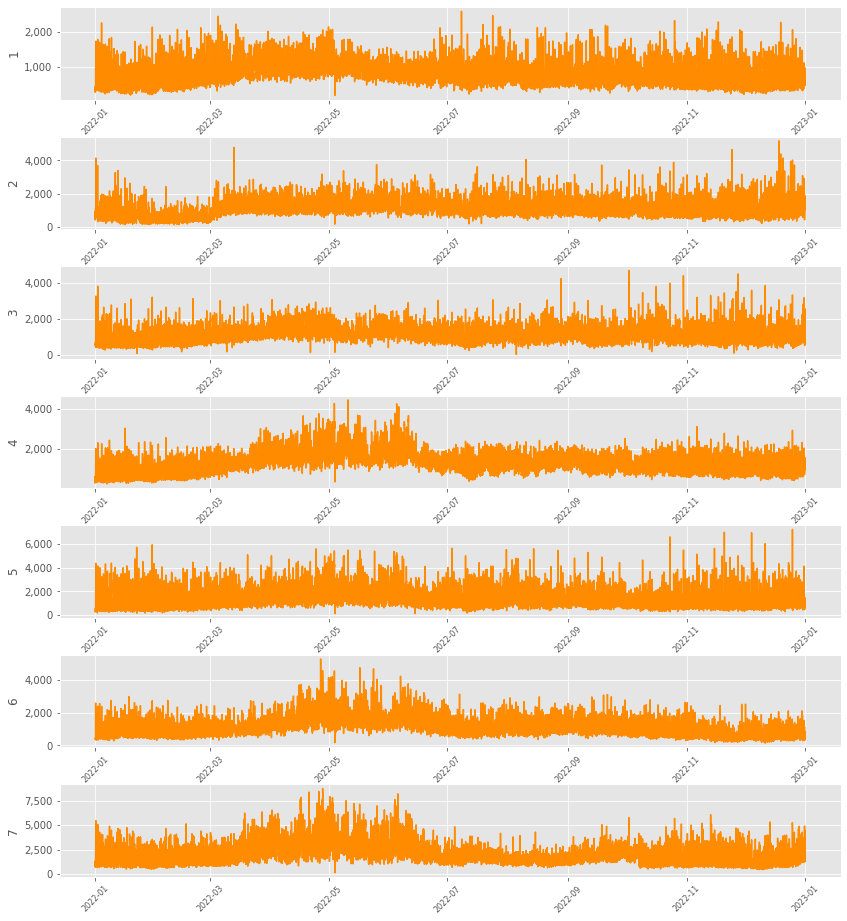

In [12]:
## Plotting features over time (with a different aspect ratio)

# Features to plot
columns = data_cluster.columns

# Creating subplot axes
fig, axes = plt.subplots(7, 1, figsize=(14,16), sharey=False)

# Iterating through axes and columns
for col, ax in zip(columns, axes.flatten()):
    sns.lineplot(data=data_cluster, x=data_cluster.index, y=col, ax=ax, color='darkorange')
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.4);

In [13]:
for i in range(1,len(data_cluster.columns)+1):
    print(f'\033[1m Cluster {i} \033[0m')
    results = adfuller(data_cluster.iloc[i]) #results object is a tuple

    # Print Dicky-Fuller test results
    print(f'Dicky-Fuller test results:{results}\n') #0th element: test statistic, 1st element: pval

    # Print test statistic
    print(f'test statistic:{results[0]}\n')

    # Print p-value
    print(f'p-value:{np.round(results[1], 3)}\n')

    # Print critical values
    print(f'critical values:{results[4]}\n') 

    # Significance statement
    alpha = 0.05

    if results[1] < alpha:
        print(f'\033[1mp-value < {alpha}: We reject the null hypothesis\nConclusion: Time series is stationary\033[0m')
    else:
        print(f'\033[1mp-value > {alpha}: We accept the null hypothesis\nConclusion: Time series is not stationary due to trend\033[0m')

 Cluster 1 
Dicky-Fuller test results:(-2.1340189752820224, 0.23105718323109153, 0, 6, {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}, 76.26452040451024)

test statistic:-2.1340189752820224

p-value:0.231

critical values:{'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}

p-value > 0.05: We accept the null hypothesis
Conclusion: Time series is not stationary due to trend
 Cluster 2 
Dicky-Fuller test results:(-1.5351639184397379, 0.5160501268845021, 1, 5, {'1%': -6.045114, '5%': -3.9292800000000003, '10%': -2.98681}, 74.36676748055848)

test statistic:-1.5351639184397379

p-value:0.516

critical values:{'1%': -6.045114, '5%': -3.9292800000000003, '10%': -2.98681}

p-value > 0.05: We accept the null hypothesis
Conclusion: Time series is not stationary due to trend
 Cluster 3 
Dicky-Fuller test results:(-2.2125621431892246, 0.20171775687704846, 1, 5, {'1%': -6.045114, '5%': -3.9292800000000003, '10%': -2.98681}, 65.94432659

In [14]:
def split_data(data, test_size=0.2, analysis='univariate'):
    """
    Function to split time series data into train and test set
    Parameters:
        test_size: float, default=0.2
        analysis: {'univariate', 'univariate'}, default='univariate'
    """
    if analysis == 'univariate':
        position = int(round(len(data) * (1-test_size)))
        train = np.array(data[:position]).reshape(-1,1)
        test = np.array(data[position:]).reshape(-1,1)
    
    elif analysis == 'multivariate':
        position = int(round(len(data) * (1-test_size)))
        train = data[:position]
        test = data[position:]
        
    else:
        print("Please specify if analysis is univariate or multivariate")
        
    return train, test

In [15]:
def scale(data, train_split):
    """
    Function to scale the entire dataset using the mean and standard deviation of the training data only
    """
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    
    return (data - data_mean) / data_std

In [16]:
def inv_scale(data, scaled_data, train_split):
    """
    Function to inverse scaling of data by using the mean and standard deviation of the training data only
    """
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
       
    return scaled_data * data_std + data_mean

In [17]:
def create_samples_univar(data, n_input, n_output):
    """
    Function to convert time series observations
    into input X and output y 
    """
    X, y = [], []
    
    for i in range(n_input, len(data)): #start, stop
        if i+n_output > len(data):
            break
        X.append(data[i-n_input : i])
        y.append(data[i : i+n_output]) 
        
    return np.array(X), np.array(y)

In [18]:
def create_samples_multivar(data, n_input, n_output, target_index=0):
    """
    Function to convert time series observations
    into input X and output y 
    """
    X, y = [], []
    
    # Move column defined by target_index to first position
    a=[]
    a = data[:, target_index].reshape(-1,1)
    b = np.delete(data, target_index, axis=1)
    data = np.concatenate((a, b), axis=1)
            
    for i in range(n_input, len(data)): #start, stop
        if i+n_output > len(data):
            break
        X.append(data[i-n_input : i, :])
        y.append(data[i : i+n_output, 0]) 
        
    return np.array(X), np.array(y)

In [19]:
def summarize_scores(name, score, scores):
    """
    Function to summarize scores
    """
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [20]:
def plot_model(history):
    """
    Function to plot training and validation loss
    """
    plt.figure(figsize=(10,5))
    plt.plot(history.history["loss"], color="r", label="Training Loss")
    plt.plot(history.history["val_loss"], color="b", label="Validation Loss")
    plt.legend(loc="upper right")
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.ylim([0, max(plt.ylim())])
    plt.title("Training and Validation Loss", fontsize=16);

2022-01-01 00:00:00    413.692308
2022-01-01 01:00:00    340.923077
2022-01-01 02:00:00    293.307692
2022-01-01 03:00:00    305.538462
2022-01-01 04:00:00    466.153846
Name: 1, dtype: float64
TRAIN_SPLIT 45
univar_data [413.69230769 340.92307692 293.30769231 ... 620.15384615 690.23076923
 487.15384615]
(8760,) [-0.75146589 -0.94377415 -1.06960799 ... -0.20584709 -0.02065383
 -0.55732805]
Shape train: (6570, 1) 
Shape test: (2190, 1) 

[[-0.75146589]
 [-0.94377415]
 [-1.06960799]
 [-1.03728557]
 [-0.61282505]]
Shape X_train y_train: (6523, 24, 1) (6523, 24, 1) 
Shape X_test y_test: (2143, 24, 1) (2143, 24, 1) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 100)               20800     
 al)                                                             
                                                                 
 dense (Dense)               (

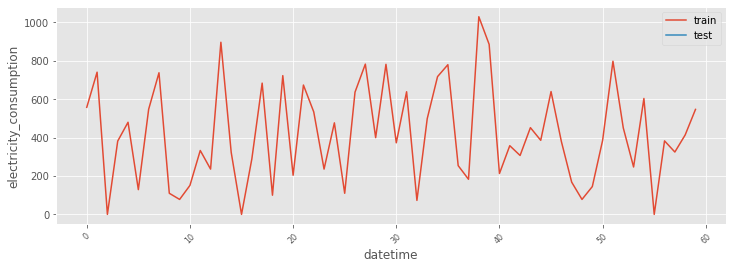

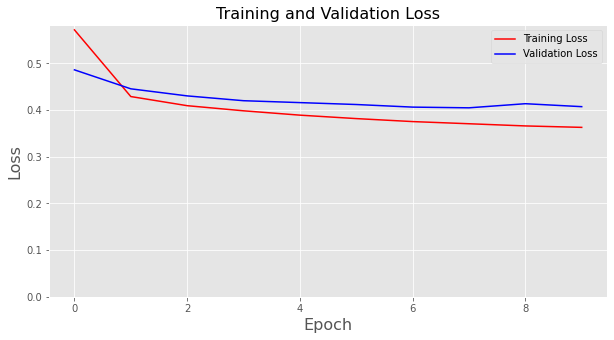

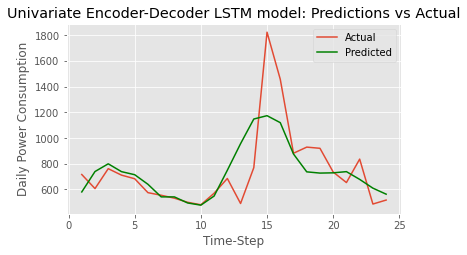

2022-01-01 00:00:00    716.50
2022-01-01 01:00:00    925.75
2022-01-01 02:00:00    430.75
2022-01-01 03:00:00    558.50
2022-01-01 04:00:00    435.50
Name: 2, dtype: float64
TRAIN_SPLIT 45
univar_data [ 716.5   925.75  430.75 ... 1332.25 1652.5  1076.5 ]
(8760,) [-0.44154876 -0.16510371 -0.81905974 ...  0.3719329   0.79502263
  0.03405562]
Shape train: (6570, 1) 
Shape test: (2190, 1) 

[[-0.44154876]
 [-0.16510371]
 [-0.81905974]
 [-0.65028624]
 [-0.8127844 ]]
Shape X_train y_train: (6523, 24, 1) (6523, 24, 1) 
Shape X_test y_test: (2143, 24, 1) (2143, 24, 1) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 100)               20800     
 al)                                                             
                                                                 
 dense (Dense)               (None, 24)                2424      
               

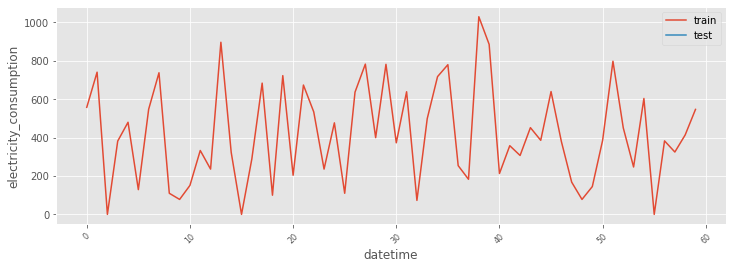

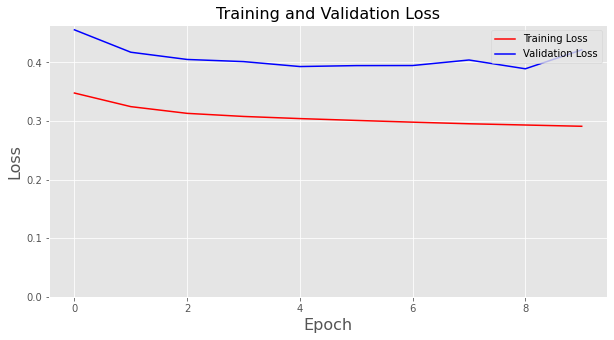

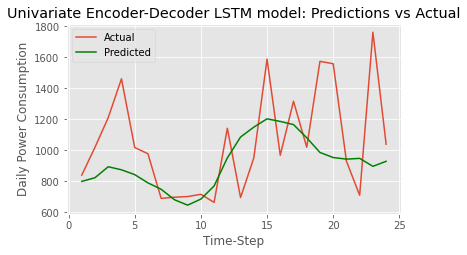

2022-01-01 00:00:00    608.333333
2022-01-01 01:00:00    594.444444
2022-01-01 02:00:00    602.444444
2022-01-01 03:00:00    529.666667
2022-01-01 04:00:00    474.111111
Name: 3, dtype: float64
TRAIN_SPLIT 45
univar_data [ 608.33333333  594.44444444  602.44444444 ... 2558.         1056.44444444
  629.11111111]
(8760,) [-0.53207245 -0.54956706 -0.53949017 ...  1.92375063  0.03237358
 -0.50590052]
Shape train: (6570, 1) 
Shape test: (2190, 1) 

[[-0.53207245]
 [-0.54956706]
 [-0.53949017]
 [-0.63116191]
 [-0.70114034]]
Shape X_train y_train: (6523, 24, 1) (6523, 24, 1) 
Shape X_test y_test: (2143, 24, 1) (2143, 24, 1) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 100)               20800     
 al)                                                             
                                                                 
 dense (Dense)          

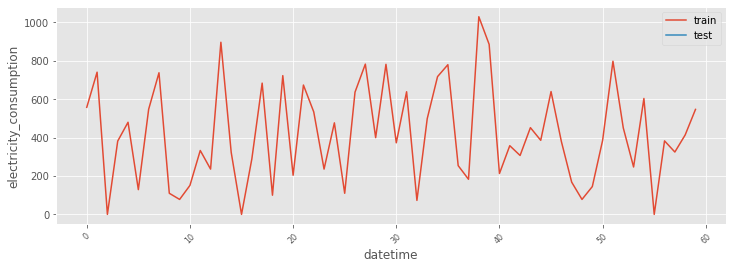

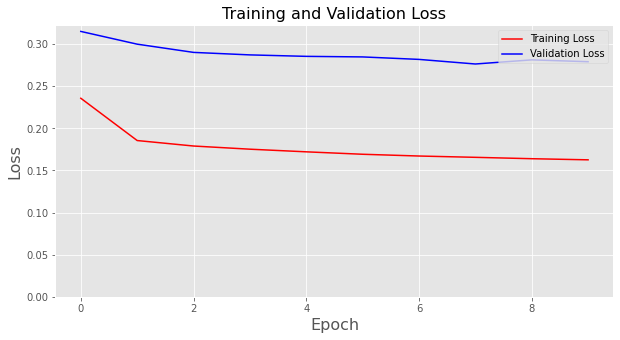

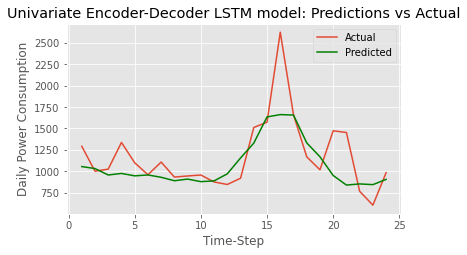

2022-01-01 00:00:00    311.666667
2022-01-01 01:00:00    627.500000
2022-01-01 02:00:00    326.555556
2022-01-01 03:00:00    324.277778
2022-01-01 04:00:00    302.388889
Name: 4, dtype: float64
TRAIN_SPLIT 45
univar_data [ 311.66666667  627.5         326.55555556 ... 1490.72222222 1357.33333333
  971.94444444]
(8760,) [-0.98624479 -0.29719081 -0.95376168 ...  1.5861022   1.2950875
  0.45428407]
Shape train: (6570, 1) 
Shape test: (2190, 1) 

[[-0.98624479]
 [-0.29719081]
 [-0.95376168]
 [-0.95873111]
 [-1.00648613]]
Shape X_train y_train: (6523, 24, 1) (6523, 24, 1) 
Shape X_test y_test: (2143, 24, 1) (2143, 24, 1) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 100)               20800     
 al)                                                             
                                                                 
 dense (Dense)           

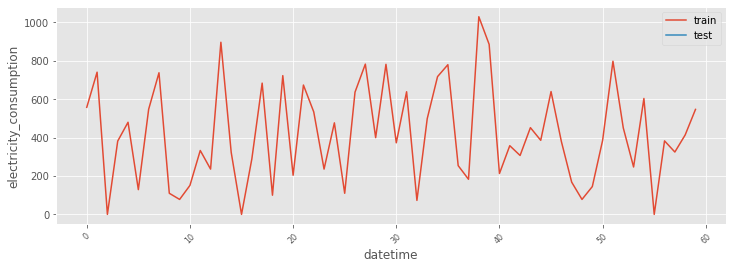

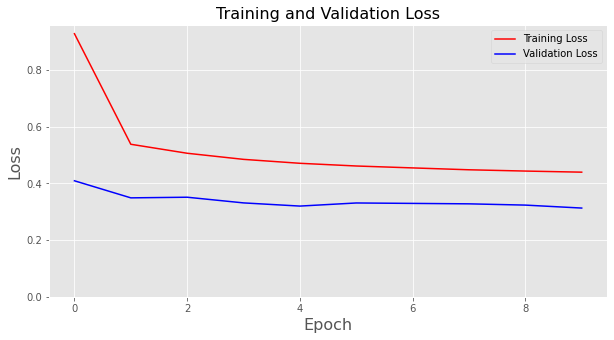

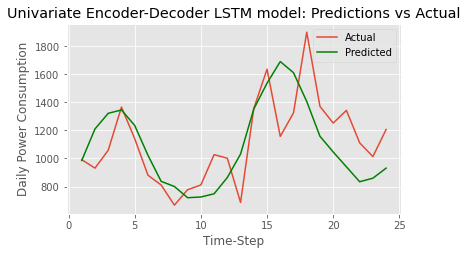

2022-01-01 00:00:00    510.333333
2022-01-01 01:00:00    396.666667
2022-01-01 02:00:00    257.333333
2022-01-01 03:00:00    286.000000
2022-01-01 04:00:00    322.333333
Name: 5, dtype: float64
TRAIN_SPLIT 45
univar_data [ 510.33333333  396.66666667  257.33333333 ... 1123.66666667 1318.
  738.        ]
(8760,) [-0.50094193 -0.60987476 -0.74340532 ...  0.08684811  0.2730881
 -0.28275682]
Shape train: (6570, 1) 
Shape test: (2190, 1) 

[[-0.50094193]
 [-0.60987476]
 [-0.74340532]
 [-0.71593252]
 [-0.68111235]]
Shape X_train y_train: (6523, 24, 1) (6523, 24, 1) 
Shape X_test y_test: (2143, 24, 1) (2143, 24, 1) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 100)               20800     
 al)                                                             
                                                                 
 dense (Dense)               (Non

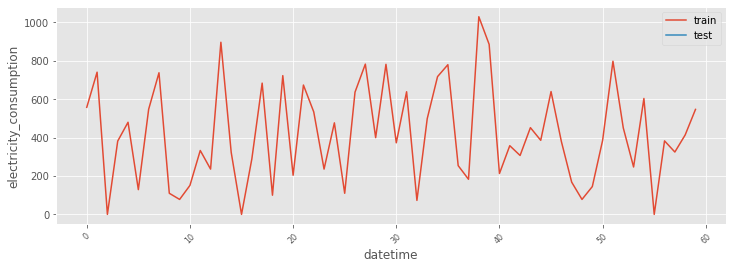

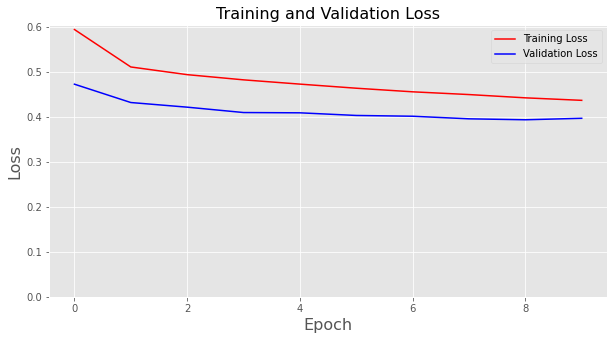

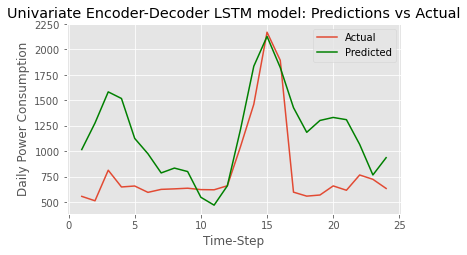

2022-01-01 00:00:00    431.750
2022-01-01 01:00:00    426.625
2022-01-01 02:00:00    413.625
2022-01-01 03:00:00    432.750
2022-01-01 04:00:00    373.125
Name: 6, dtype: float64
TRAIN_SPLIT 45
univar_data [431.75  426.625 413.625 ... 676.    543.5   450.5  ]
(8760,) [-0.75246636 -0.76181795 -0.78553907 ... -0.30678301 -0.54855596
 -0.7182532 ]
Shape train: (6570, 1) 
Shape test: (2190, 1) 

[[-0.75246636]
 [-0.76181795]
 [-0.78553907]
 [-0.75064165]
 [-0.85943948]]
Shape X_train y_train: (6523, 24, 1) (6523, 24, 1) 
Shape X_test y_test: (2143, 24, 1) (2143, 24, 1) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 100)               20800     
 al)                                                             
                                                                 
 dense (Dense)               (None, 24)                2424      
          

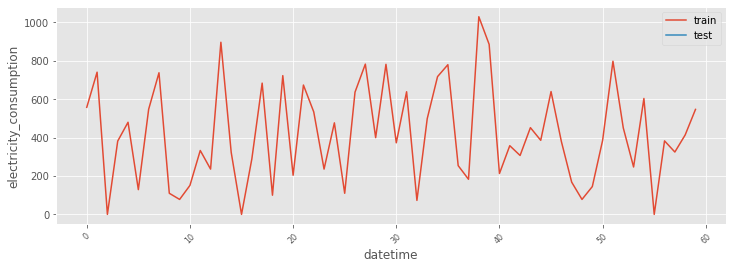

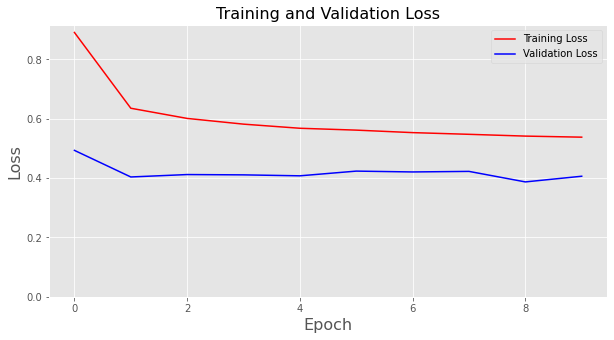

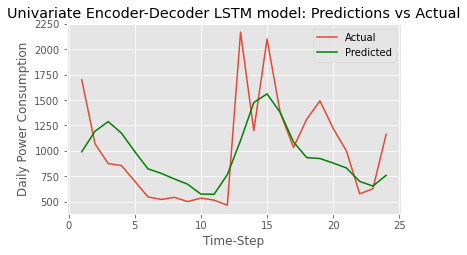

2022-01-01 00:00:00     787.8
2022-01-01 01:00:00    1355.6
2022-01-01 02:00:00    1173.2
2022-01-01 03:00:00     784.8
2022-01-01 04:00:00     712.0
Name: 7, dtype: float64
TRAIN_SPLIT 45
univar_data [ 787.8 1355.6 1173.2 ... 2550.2 3571.8 1287.6]
(8760,) [-1.00572776 -0.49768824 -0.6608908  ...  0.57118109  1.48525853
 -0.5585313 ]
Shape train: (6570, 1) 
Shape test: (2190, 1) 

[[-1.00572776]
 [-0.49768824]
 [-0.6608908 ]
 [-1.00841202]
 [-1.07354988]]
Shape X_train y_train: (6523, 24, 1) (6523, 24, 1) 
Shape X_test y_test: (2143, 24, 1) (2143, 24, 1) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 100)               20800     
 al)                                                             
                                                                 
 dense (Dense)               (None, 24)                2424      
                     

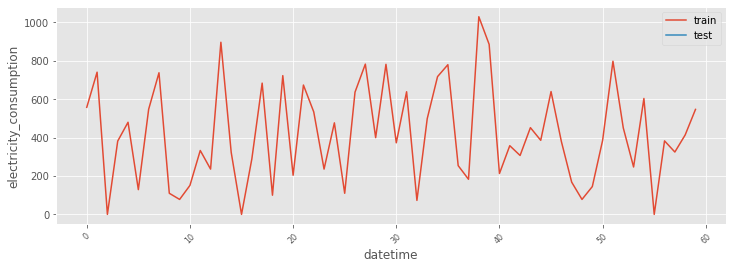

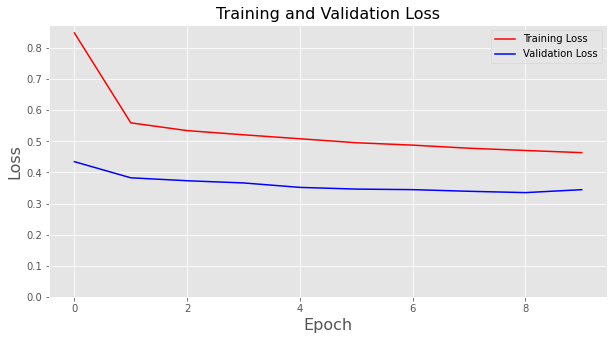

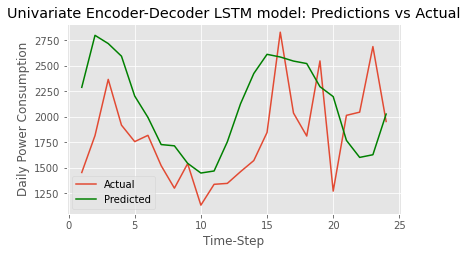

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Input data: clusters (total daily consumption)
for i in range(1, len(data_cluster.columns) + 1):
    # Input data: cluster 1 (total daily consumption)
    feature = data_cluster.T.iloc[i-1]
    print(feature.head())
    
    # Define train/test split
    test_size = 0.25
    TRAIN_SPLIT = int(round(len(dataset) * (1 - test_size)))
    print("TRAIN_SPLIT", TRAIN_SPLIT)
    
    # Get data values
    univar_data = feature.values
    print("univar_data", univar_data)
    
    # Scale data (using training data)
    univar_data_scaled = scale(univar_data, TRAIN_SPLIT)
    print(univar_data_scaled.shape, univar_data_scaled)
    
    # Split data into train and test
    train, test = split_data(data=univar_data_scaled, test_size=test_size, analysis='univariate')

    # Print shape and first 5 values for train set
    print("Shape train:", train.shape, "\nShape test:", test.shape, '\n')
    print(train[:5])
    
    # Visualize train/test split
    plt.figure(figsize=(12, 4))
    plt.plot(dataset.iloc[:len(train), 5])
    plt.plot(dataset.iloc[len(train):, 5])
    plt.xlabel('datetime')
    plt.ylabel("electricity_consumption")
    plt.tick_params(axis='x', labelrotation=45, labelsize=8)
    plt.legend(['train', 'test'])
    
    # Create samples for train and test set
    n_input = 24
    n_output = 24

    X_train, y_train = create_samples_univar(train, n_input=n_input, n_output=n_output)
    X_test, y_test = create_samples_univar(test, n_input=n_input, n_output=n_output)

    # Print shape and first 3 values for train set
    print("Shape X_train y_train:", X_train.shape, y_train.shape,
          "\nShape X_test y_test:", X_test.shape, y_test.shape, '\n')

    # Create model
    clear_session()

    n_features = X_train.shape[2]
    n_input = X_train.shape[1]
    n_output = y_train.shape[1]

    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_input, n_features)))
    model.add(Dense(n_output))
    #model.add(RepeatVector(n_output))
    #model.add(LSTM(100, activation='relu', return_sequences=True))
    #model.add(TimeDistributed(Dense(50, activation='relu')))
    #model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    print(model.summary())
    
    # Fit model
    epochs = 10
    verbose = 0
    batch_size = 16

    history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, validation_data=(X_test, y_test))
    plot_model(history)
    
    # Loss and mae value for the model in test mode
    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {score[0]:.4f}') 
    print(f'Test mae: {score[1]:.4f}')
    
    # Make prediction
    yhat = model.predict(X_test, verbose=0)

    # Inverse scaling of prediction
    yhat_inv = inv_scale(univar_data, yhat, TRAIN_SPLIT)
    y_test_inv = inv_scale(univar_data, y_test, TRAIN_SPLIT)

    # Flatten actual and predicted arrays for metrics
    actual_flat = y_test_inv.flatten()
    predicted_flat = yhat_inv.flatten()

    print("Flattened actual shape:", actual_flat.shape)
    print("Flattened predicted shape:", predicted_flat.shape)

    # Calculate overall metrics
    rmse_total = mean_squared_error(actual_flat, predicted_flat, squared=False)
    mae_total = mean_absolute_error(actual_flat, predicted_flat)
    mape_total = np.mean(np.abs((actual_flat - predicted_flat) / actual_flat)) * 100
    smape_total = 100 * np.mean(2 * np.abs(actual_flat - predicted_flat) / (np.abs(actual_flat) + np.abs(predicted_flat)))
    r_squared_total = r2_score(actual_flat, predicted_flat)

    # Print overall metrics
    print("\nOverall Metrics:")
    print(f"RMSE: {rmse_total:.3f}")
    print(f"MAE: {mae_total:.3f}")
    print(f"MAPE: {mape_total:.2f}%")
    print(f"sMAPE: {smape_total:.2f}%")
    print(f"R-squared: {r_squared_total:.3f}")

    # Plot metrics
    plt.figure(figsize=(6, 3.5))
    future_seq = np.arange(1, len(y_test[0]) + 1)
    plt.plot(future_seq, actual_flat[:len(future_seq)], label='Actual')
    plt.plot(future_seq, predicted_flat[:len(future_seq)], label='Predicted', color='green')
    plt.xlabel('Time-Step')
    plt.ylabel('Daily Power Consumption')
    plt.title('Univariate Encoder-Decoder LSTM model: Predictions vs Actual')
    plt.legend()
    plt.show()


cluster                       1       2           3           4           5  \
2022-01-01 00:00:00  413.692308  716.50  608.333333  311.666667  510.333333   
2022-01-01 01:00:00  340.923077  925.75  594.444444  627.500000  396.666667   
2022-01-01 02:00:00  293.307692  430.75  602.444444  326.555556  257.333333   
2022-01-01 03:00:00  305.538462  558.50  529.666667  324.277778  286.000000   
2022-01-01 04:00:00  466.153846  435.50  474.111111  302.388889  322.333333   

cluster                    6       7  
2022-01-01 00:00:00  431.750   787.8  
2022-01-01 01:00:00  426.625  1355.6  
2022-01-01 02:00:00  413.625  1173.2  
2022-01-01 03:00:00  432.750   784.8  
2022-01-01 04:00:00  373.125   712.0  
TRAIN_SPLIT 45
univar_data [[ 413.69230769  716.5         608.33333333 ...  510.33333333
   431.75        787.8       ]
 [ 340.92307692  925.75        594.44444444 ...  396.66666667
   426.625      1355.6       ]
 [ 293.30769231  430.75        602.44444444 ...  257.33333333
   413.625      

KeyboardInterrupt: 

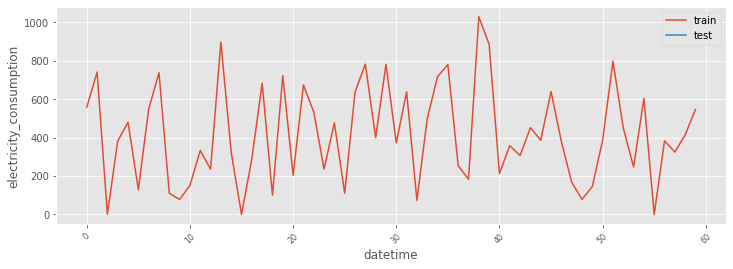

In [30]:
# Input data: clusters (total daily consumption)
for i in range(1,len(data_cluster.columns)+1):
    # Input data: cluster 1 (total daily consumption)
    feature = data_cluster
    print(feature.head())
    # Define train/test split
    test_size = 0.25
    TRAIN_SPLIT = int(round(len(dataset) * (1-test_size)))
    print("TRAIN_SPLIT",TRAIN_SPLIT)
    # Get data values
    univar_data = feature.values
    print("univar_data",univar_data)
    # Scale data (using training data)
    univar_data_scaled = scale(univar_data, TRAIN_SPLIT)
    print(univar_data_scaled.shape, univar_data_scaled)
    # Split data into train and test
    train, test = split_data(data=univar_data_scaled, test_size=test_size, analysis='univariate')

    # Print shape and first 5 values for train set
    print("Shape train:", train.shape, "\nShape test:", test.shape, '\n')
    print(train[:5])
    # Visualize train/test split
    plt.figure(figsize=(12,4))
    plt.plot(dataset.iloc[:len(train), 5])
    plt.plot(dataset.iloc[len(train):, 5])
    plt.xlabel('datetime')
    plt.ylabel("electricity_consumption")
    plt.tick_params(axis='x', labelrotation=45, labelsize=8)
    plt.legend(['train','test']);
    # Create samples for train and test set
    n_input = 48
    n_output = 24

    X_train, y_train = create_samples_univar(train, n_input=n_input, n_output=n_output)
    X_test, y_test = create_samples_univar(test, n_input=n_input, n_output=n_output)

    # Print shape and first 3 values for train set
    print("Shape X_train y_train:", X_train.shape, y_train.shape,
          "\nShape X_test y_test:", X_test.shape, y_test.shape, '\n')
    for i in range(2):
        print(X_train[i], y_train[i])
    #print(train[-5:], test[-5:])
    #print(X_train[-1], y_train[-1])
    #print(X_test[-1], y_test[-1])
    #print(X_train[0], y_train[0])
    #print(X_test[0], y_test[0])

    # Create model
    clear_session()

    n_features = X_train.shape[2]
    n_input = X_train.shape[1]
    n_output = y_train.shape[1]

    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
    model.add(RepeatVector(n_output))
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(50, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam', loss='mse', metrics='mae')

    print(model.summary())
    
    # Fit model
    epochs = 10
    verbose = 0
    batch_size = 16 #default 32

    history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose,batch_size=batch_size, validation_data=(X_test, y_test))
    plot_model(history)
    
    # Loss and mae value for the model in test mode
    score = model.evaluate(X_test, y_test, verbose = 0)
    print(f'Test loss: {score[0]:.4f}') 
    print(f'Test mae: {score[1]:.4f}')
    # List all data in history
    print(history.history.keys())
    print(history.history["loss"][:5])
    print(history.history["mae"][:5])
    # Reshape data for prediction into [1, n_input, 1]
    x_input = X_test[0].reshape((1, len(X_test[0]), 1))
    print(x_input.shape)
    # Make prediction
    yhat = model.predict(x_input, verbose=0)

    print(yhat.shape)
    print(yhat)

    # Inverse scaling of prediction
    yhat_inv = inv_scale(univar_data, yhat, TRAIN_SPLIT)
    print(yhat_inv.shape)
    print(yhat_inv)

    # Inverse scaling of X_test, y_test
    X_test_inv = inv_scale(univar_data, X_test, TRAIN_SPLIT)
    y_test_inv = inv_scale(univar_data, y_test, TRAIN_SPLIT)

    print(X_test_inv.shape, y_test_inv.shape)
    # Plot prediction
    plt.figure(figsize=(6,3.5))

    past_seq = range(-len(X_test[0])+1, 1)
    future_seq = np.arange(1, len(y_test[0])+1)

    plt.plot(past_seq, X_test_inv[0], color='blue', marker='.', label='History')
    plt.plot(future_seq, y_test_inv[0], marker='x', label='True Future')
    plt.plot(future_seq, yhat_inv.reshape(-1,1), color='green', marker='o', label='Model Prediction')

    plt.xlabel('Time-Step')
    plt.ylabel('Daily Power Consumption (kW)')
    plt.xticks(range(-n_input,n_output,2))
    plt.title('Univariate Encoder-Decoder LSTM model: Multi-step prediction')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10);

    ## Now randomly select 3 more samples from the test set, perform model prediction and plot results 

    for i in random.sample(range(len(X_test)), 3):
        print(f"Randomly selected sample: {i}")

        # Reshape data for prediction into [1, n_input, 1]
        x_input = X_test[i].reshape((1, len(X_test[i]), 1))

        # Make prediction
        pred = model.predict(x_input, verbose=0)

        # Inverse scaling of prediction
        pred_inv = inv_scale(univar_data, pred, TRAIN_SPLIT)

        # Plot prediction
        plt.figure(figsize=(6,3.5))

        past_seq = range(-len(X_test[0])+1, 1)
        future_seq = np.arange(1, len(y_test[0])+1)

        plt.plot(past_seq, X_test_inv[i], color='blue', marker='.', label='History')
        plt.plot(future_seq, y_test_inv[i], marker='x', label='True Future')
        plt.plot(future_seq, pred_inv.reshape(-1,1), color='green', marker='o', label='Model Prediction')

        plt.xlabel('Time-Step')
        plt.ylabel('Daily Power Consumption (kW)')
        plt.xticks(range(-n_input,n_output,2))
        plt.title('Univariate Encoder-Decoder LSTM model: Multi-step prediction')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10);

    # Actual values
    actual = y_test_inv[0]

    # Predicted values
    predicted = yhat_inv.reshape(-1,1)
    print(actual.shape, predicted.shape)
    print("actual:",actual)
    print("predicted",predicted)
    
    # Calculate RMSE score for each day
    rmse_hour = []

    for i in range(actual.shape[0]):
        # calculate rmse
        rmse = mean_squared_error(actual[i], predicted[i], squared=False)
        rmse_hour.append(rmse)

    print(rmse_hour)
    # Store RMSE scores of each day in df
    df_rmse =pd.DataFrame()
    df_rmse['Univariate Encoder-Decoder LSTM'] = rmse_hour
    # Plot RMSE score for each hour
    future_seq = np.arange(1, len(y_test[0])+1)

    plt.figure(figsize=(6,3.5))
    plt.plot(future_seq, rmse_hour, marker='o', color='darkred')
    plt.xlabel('Time-Step')
    plt.ylabel('RMSE (kW)')
    plt.title('Univariate Encoder-Decoder LSTM model: RMSE per hour forecast');

    # Calculate overall RMSE score (for the respective forecast period)
    rmse_total = mean_squared_error(actual, predicted, squared=False)
    print(rmse_total)

    # Store overall RMSE score in dict
    performance_rmse = {}
    performance_rmse.update( {'Univariate Encoder-Decoder LSTM' : rmse_total} )

    # Summarize scores
    summarize_scores('RMSE scores for Univariate Stacked LSTM [total] per hour', rmse_total, rmse_hour)


 Encoder-Decoder LSTM Model
    